# Fase Paraxial

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation

In [2]:
w = 632 * (10 ** -9)
a = 5*w
p = [[a,a],[a,-a],[-a,a],[-a,-a],[2*a,2*a],[2*a,-2*a],[-2*a,2*a],[-2*a,-2*a],[0,0],[-2*a,0],[2*a,0],[0,-2*a],[0,2*a],[a,0],[-a,0]]

In [3]:
def matrix_points(p):
    #x son los puntos sobre el eje x
    x = list(np.array(p)[:,0])
    y = list(np.array(p)[:,1])
    
    #subm_1 es la submatriz compuesta de vectores fila de x
    subm_1x = np.array(x*len(x)).reshape(len(x),len(x))
    subm_1y = np.array(y*len(y)).reshape(len(y),len(y))
    
    #subm_2 es la submatriz compuesta de vectores columna repitiendo x
    subm_2x = np.transpose(subm_1x)
    subm_2y = np.transpose(subm_1y)
    
    #xi_a es el promedio de cada punto en x con cada uno de los demas puntos
    xi_a = (subm_1x+subm_2x)/2
    eta_a = (subm_1y+subm_2y)/2
    
    #xi_d es la distancia de cada punto con cada uno de los demas puntos
    xi_d = subm_2x-subm_1x
    eta_d = subm_2y-subm_1y
    
    #vectores de las matrices xi_a y xi_d
    xi_av = list(xi_a.reshape(1,len(xi_a)**2))
    xi_dv = list(xi_d.reshape(1,len(xi_d)**2))
    eta_av = list(eta_a.reshape(1,len(eta_a)**2))
    eta_dv = list(eta_d.reshape(1,len(eta_d)**2))
    
    #matriz con todas las parejas de puntos xi_a y xi_d
    xi_m = np.transpose(np.array(xi_av+xi_dv+eta_av+eta_dv)).reshape(len(x),len(x),4)
    return xi_m

In [4]:
def GeometricPotencial_3D_00_reducido(xa, xi_a, xi_d, ya, eta_a, eta_d, za, wa):
    #vectores
    phase = 0
    xi_p, xi_n = xi_a+(xi_d)/2, xi_a-(xi_d)/2
    eta_p, eta_n = eta_a+(eta_d)/2, eta_a-(eta_d)/2
    
    focal_point = 35*w
    
    #distancia s
    s_1 = np.sqrt(((xa-xi_p) ** 2) + ((ya-eta_p) **2) + ((za) ** 2))
    s_2 = np.sqrt(((xa-xi_n) **2) + ((ya-eta_n) ** 2) + ((za) ** 2))
    
    s_1f = np.sqrt(((xa-2*xi_p) ** 2) + ((ya-2*eta_p) **2) + ((za+focal_point) ** 2))
    s_2f = np.sqrt(((xa-2*xi_n) **2) + ((ya-2*eta_n) ** 2) + ((za+focal_point) ** 2))
    
    phase_paraxial = np.sqrt(((-xi_p) ** 2) + ((-eta_p) **2) + ((focal_point) ** 2)) - np.sqrt(((-xi_n) **2) + ((-eta_n) ** 2) + ((focal_point) ** 2))
    #phase_paraxial = ((xa**2) + (ya**2)) /2
    
    #constantes
    pic = 1 / ((4*np.pi) ** 2)
    k = ((2*np.pi)/wa)
    
    #kernel
    #kernel = 2*((k**2)*pic) * ((za+0.5*s_1)/(s_1 ** 2)) * ((za+0.5*s_2)/(s_2 ** 2)) * np.cos(k*s_1-k*s_2+phase)
    kernel_0 = 2*((k**2)*pic) * ((za+s_1)/(s_1 ** 2)) * ((za+s_2)/(s_2 ** 2)) * np.exp(1j*k*s_1-1j*k*s_2+phase) * np.exp(1j*k*phase_paraxial*focal_point)
    kernel = np.real(kernel_0)
    return kernel, np.real(np.exp(1j*k*phase_paraxial*focal_point))

def GeometricPotencial_3D_Real(xa, ya, za, p, wa):
    sum_r = 0
    matrix_complete = matrix_points(p)
    matrix_real = np.einsum('iij->ij', matrix_complete)
    for i in matrix_real:
        sum_r = sum_r + GeometricPotencial_3D_00_reducido(xa,i[0],i[1],ya,i[2],i[3],za,wa)[0]
    return sum_r

def GeometricPotencial_3D_Virtual(xa, ya, za, p, wa,c):
    sum_v = 0
    matrix_complete = matrix_points(p)
    matrix_virtual = []
    
    for i in range(0,len(matrix_complete)):
        for j in range(0,len(matrix_complete)):
            if i != j:
                matrix_virtual.append(list(matrix_complete[i,j]))
    
    matrix_virtual = np.array(matrix_virtual)
    
    for k in matrix_virtual:
        sum_v = sum_v + GeometricPotencial_3D_00_reducido(xa,k[0],k[1],ya,k[2],k[3],za,wa)[0]
        #print(GeometricPotencial_3D_00_reducido(xa,k[0],k[1],ya,k[2],k[3],za,wa)[1])
    return sum_v

def GeometricPotencial_3D_reducido(xa, ya, za, p, wa,c):
    sum_t = 1*GeometricPotencial_3D_Real(xa, ya, za, p, wa) + 1*GeometricPotencial_3D_Virtual(xa, ya, za, p, wa,c)
    return sum_t

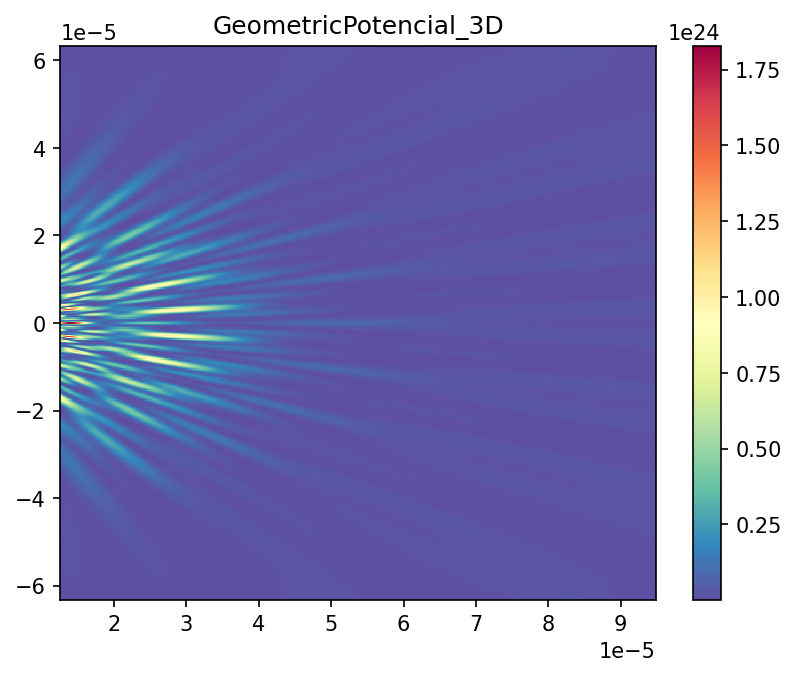

CPU times: user 13.1 s, sys: 20.9 ms, total: 13.2 s
Wall time: 13.1 s


In [11]:
%%time
phase = 0
yy,zzz = np.meshgrid(np.linspace(-100*w, 100*w, 500), np.linspace(20*w, 150*w, 1000))
zz = np.array(list(GeometricPotencial_3D_reducido(0,yy,zzz,p,w,phase)), dtype=float)
#zz = zz[:-1, :-1]
z_min, z_max = zz.min()/1, zz.max()/1

fig, ax = plt.subplots(dpi=150)
c = ax.pcolormesh(zzz, yy, zz, cmap='Spectral_r',  vmin = z_min, vmax = z_max)
fig.colorbar(c, ax = ax)
ax.set_title('GeometricPotencial_3D')
#plt.savefig("Confinamiento")
plt.show()

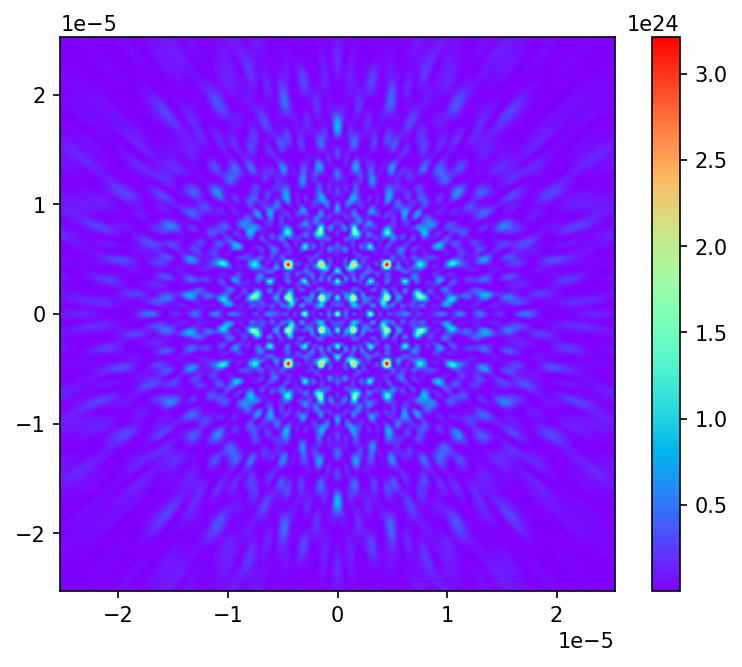

CPU times: user 23.5 s, sys: 2.91 s, total: 26.4 s
Wall time: 26.4 s


1.2640000000000001e-05

In [6]:
%%time
square = np.linspace(-40*w, 40*w, 1000)
dz = 20*w
phase = 0
xx,yy = np.meshgrid(square, square)
zz = np.array(list(GeometricPotencial_3D_reducido(xx,yy,dz,p,w,phase)), dtype=float)
#zz = zz[:-1, :-1]
z_min, z_max = zz.min()/1, zz.max()/1

fig, (ax) = plt.subplots(dpi=150, subplot_kw={'aspect': 'equal'})
c = ax.pcolormesh(xx, yy, zz, cmap='rainbow',  vmin = z_min, vmax = z_max)
fig.colorbar(c, ax = ax)
plt.savefig("Geometric Potencial_coherence")
plt.show()
dz

In [7]:
k = ((2*np.pi)/w)
np.exp(1j*a*k*2*35*w*2000), k

((-0.9352217514007471+0.35406253078646854j), 9941748.903765168)